In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import rsciio.digitalmicrograph as dm
import matplotlib.pyplot as plt


In [34]:
path_to_data = "../Data/hBN-200kV-stem-eels-core-loss-loc_002.dm4"
raw_data = dm.file_reader(path_to_data)
print(raw_data)


[{'data': array([3455.7942, 3833.722 , 3546.6719, ..., 7856.516 , 7442.254 ,
       7391.302 ], dtype=float32), 'axes': [{'name': 'Energy loss', 'size': 2048, 'index_in_array': 0, 'scale': np.float64(0.014999999664723873), 'offset': np.float64(184.0000007700919), 'units': 'eV', 'navigate': False}], 'metadata': {'General': {'title': 'hBN-200kV-stem-eels-core-loss-loc_002', 'original_filename': 'hBN-200kV-stem-eels-core-loss-loc_002.dm4'}, 'Signal': {'signal_type': 'EELS'}}, 'original_metadata': {'root': {}, 'ApplicationBounds': (0, 0, 1519, 2363), 'DocumentObjectList': {'TagGroup0': {'AnnotationGroupList': {}, 'AnnotationType': 20, 'BackgroundColor': (-1, -1, -1), 'BackgroundMode': 2, 'FillMode': 2, 'ForegroundColor': (-1, -1, -1), 'HasBackground': 0, 'ImageDisplayInfo': {'BackgroundColor': (-5655, -5655, -5655), 'BackgroundOn': 1, 'CalibrationSliceId': {'Data0': 0}, 'CaptionAttributes': 7, 'CaptionColor': (0, 0, 0), 'CaptionFaceName': 'Lucida Sans Unicode', 'CaptionOn': 1, 'CaptionSize

In [35]:
path_to_data = "../data/008_core_loss_line_020evpx_1mm.dm3"

raw_data = dm.file_reader(path_to_data)

# Extracting the core loss data
core_loss_data = raw_data[0]['data'][:500,:]
# core_loss_data[core_loss_data>4000] = 0

# Extracting the energy loss axis and spatial axis
energy_loss_md = raw_data[0]['axes'][1]
begin, dispersion, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
energy_loss_axis = np.linspace(begin, begin + dispersion * (size - 1), size)

spatial_md = raw_data[0]['axes'][0]
begin, step, size = spatial_md['offset'], spatial_md['scale'], spatial_md['size']
spatial_axis = np.linspace(begin, begin + step * (size - 1), size)

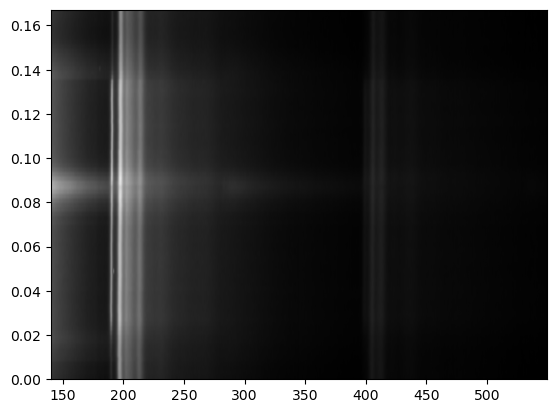

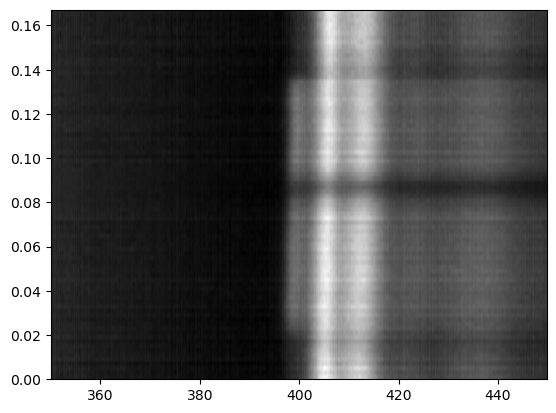

In [36]:
plt.imshow(core_loss_data, cmap='gray', aspect='auto', extent=
        [energy_loss_axis[0], energy_loss_axis[-1], spatial_axis[0], spatial_axis[-1]])
plt.show()
# core_loss_data_trimmed = np.concatenate((core_loss_data[:14,1500:], core_loss_data[75:,1500:]))
window = (energy_loss_axis > 350) & (energy_loss_axis < 450)
core_loss_data_trimmed = core_loss_data[:, window]

core_loss_data_trimmed /= core_loss_data_trimmed[:,0].reshape(-1, 1)
energy_loss_axis_trimmed = energy_loss_axis[window]
plt.imshow(core_loss_data_trimmed, cmap='gray', aspect='auto', extent=
        [energy_loss_axis_trimmed[0], energy_loss_axis_trimmed[-1], spatial_axis[0], spatial_axis[-1]])

In [37]:
intensities = torch.tensor(core_loss_data_trimmed, dtype=torch.float32)  
energy_axis = torch.tensor(energy_loss_axis_trimmed, dtype=torch.float32)
spatial_axis = torch.tensor(spatial_axis, dtype=torch.float32)

exclude_min = 0
exclude_max = 0
mask = (energy_axis < exclude_min) | (energy_axis > exclude_max)

filtered_energy_axis = energy_axis[mask]
filtered_intensities = intensities[:, mask]


# include_spectra_mask = ((spatial_axis < 0.13) & (spatial_axis > 0.09)) | ((spatial_axis < 0.08) & (spatial_axis > 0.03))

# filtered_intensities = filtered_intensities[include_spectra_mask,:]
# filtered_spatial_axis = spatial_axis[include_spectra_mask]

num_spectra, num_energy_loss = filtered_intensities.shape

log_total_intensity = torch.log(intensities.sum(dim=1, keepdim=True))

energy_axis_expanded = filtered_energy_axis.unsqueeze(0).expand(num_spectra, -1)
log_total_intensity_expanded = log_total_intensity.expand(-1, num_energy_loss)

X = torch.stack([
    energy_axis_expanded, 
    log_total_intensity_expanded
], dim=2)
X = X.reshape(-1, 2)

y = torch.log(filtered_intensities.reshape(-1))

X_mean = X.mean(dim=0)
X_std = X.std(dim=0)

X = (X - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()

y = (y - y_mean) / y_std

In [38]:
class EELSBackgroundNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10, 15),
            nn.Sigmoid(),
            nn.Linear(15, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1),
        )
    def forward(self, x):
        return self.model(x)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EELSBackgroundNet().to(device)
X, y = X.to(device), y.to(device)

print("Using device:", device)
print("Input shape:", X.shape)
print("Target shape:", y.shape)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

lambda_mono = 0.1  # Weight for monotonicity penalty

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

n_epochs = 10
cost = []
E_cutoff = (390-X_mean[0])/X_std[0]
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in dataloader:
        batch_X.requires_grad_(True)

        predictions = model(batch_X).squeeze()
        
        energies = batch_X[:, 0]
        
        mask_low = energies <= E_cutoff
        mask_high = energies > E_cutoff

        if mask_low.any():
            mse_loss = loss_function(predictions[mask_low], batch_y[mask_low])

        # Derivative Penalties
        if mask_high.any():
            grads = torch.autograd.grad(
                outputs=predictions,
                inputs=batch_X,
                grad_outputs=torch.ones_like(predictions),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]

            # First derivative w.r.t energy
            d_pred_dE = grads[:, 0]

            # Second derivative
            second_grads = torch.autograd.grad(
                outputs=d_pred_dE,
                inputs=batch_X,
                grad_outputs=torch.ones_like(d_pred_dE),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]

            d2_pred_dE2 = second_grads[:, 0]

            mono_penalty = torch.relu(d_pred_dE[mask_high]).mean()
            smoothness_penalty = d2_pred_dE2[mask_high].pow(2).mean()
        else:
            mono_penalty = torch.tensor(0.0, device=predictions.device)
            smoothness_penalty = torch.tensor(0.0, device=predictions.device)

        lambda_smooth = 0 
        loss = mse_loss + lambda_mono * mono_penalty + lambda_smooth * smoothness_penalty   

        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    cost.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}")



Using device: cpu
Input shape: torch.Size([42000, 2])
Target shape: torch.Size([42000])
Epoch 1/10, Loss: 89.3176
Epoch 2/10, Loss: 46.9217
Epoch 3/10, Loss: 34.1304
Epoch 4/10, Loss: 7.7239
Epoch 5/10, Loss: 6.4860
Epoch 6/10, Loss: 6.4370
Epoch 7/10, Loss: 6.4037
Epoch 8/10, Loss: 6.4052
Epoch 9/10, Loss: 6.3333
Epoch 10/10, Loss: 6.3338


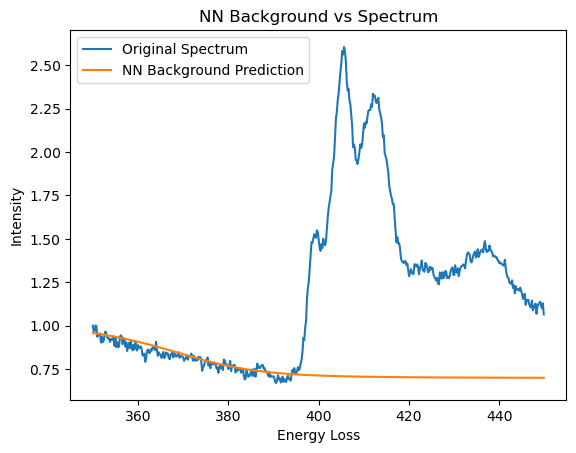

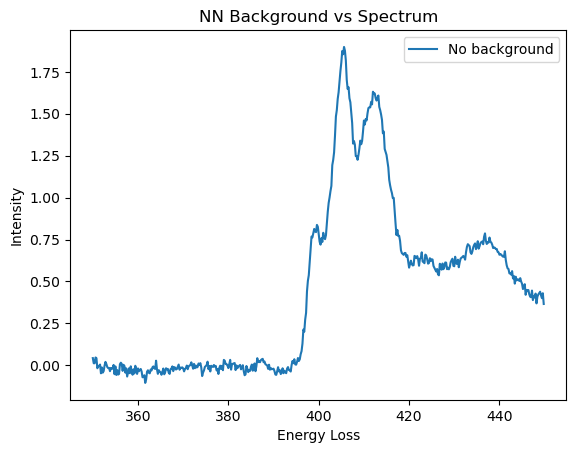

In [40]:
spectrum = intensities[50]
log_total = torch.log(spectrum.sum())

X_single = torch.stack([
    energy_axis, 
    log_total.expand_as(energy_axis)
], dim=1)

X_single = (X_single - X_mean) / X_std
# print(X_single)
model.eval()
with torch.no_grad():
    pred_log = model(X_single.to(device)).squeeze()

pred_log = pred_log * y_std + y_mean
pred = torch.exp(pred_log)

import matplotlib.pyplot as plt

plt.plot(energy_axis.cpu(), spectrum.cpu(), label="Original Spectrum")
plt.plot(energy_axis.cpu(), pred.cpu(), label="NN Background Prediction")
plt.xlabel("Energy Loss")
plt.ylabel("Intensity")
plt.legend()
plt.title("NN Background vs Spectrum")
plt.show()

plt.plot(energy_axis.cpu(), spectrum.cpu()-pred.cpu(), label="No background")
# plt.plot(energy_axis.cpu(), pred.cpu(), label="NN Background Prediction")
plt.xlabel("Energy Loss")
plt.ylabel("Intensity")
plt.legend()
plt.title("NN Background vs Spectrum")
plt.show()



Text(0, 0.5, 'Loss')

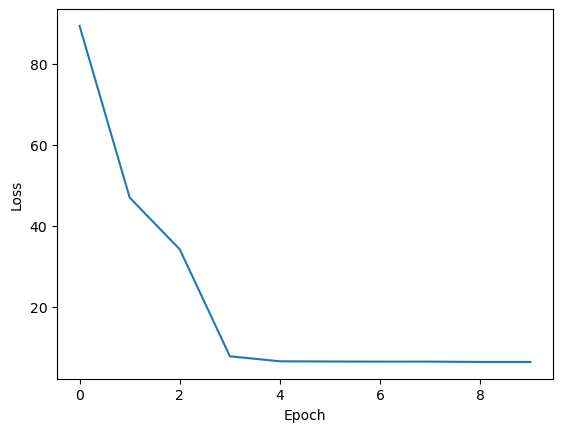

In [41]:
plt.plot(cost, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

C:\Users\bartv\AppData\Local\Temp\ipykernel_7964\1559428499.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spectrum_no_background[i] = spectrum - pred.cpu()


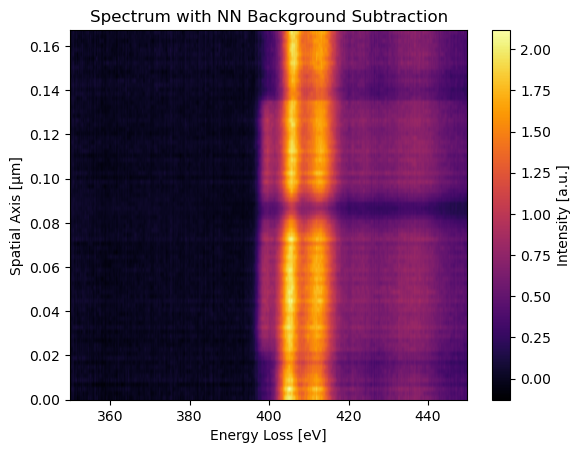

In [42]:
spectrum_no_background = np.zeros_like(intensities)
for i, spectrum in enumerate(intensities):
    log_total = torch.log(spectrum.sum())

    X_single = torch.stack([
        energy_axis, 
        log_total.expand_as(energy_axis)
    ], dim=1)

    X_single = (X_single - X_mean) / X_std
    model.eval()
    with torch.no_grad():
        pred_log = model(X_single.to(device)).squeeze()

    pred_log = pred_log * y_std + y_mean
    pred = torch.exp(pred_log)
    spectrum_no_background[i] = spectrum - pred.cpu()

plt.imshow(spectrum_no_background, cmap='inferno', aspect='auto', extent=
        [energy_loss_axis_trimmed[0], energy_loss_axis_trimmed[-1], spatial_axis[0], spatial_axis[-1]])
plt.colorbar(label="Intensity [a.u.]")
plt.xlabel("Energy Loss [eV]")
plt.ylabel("Spatial Axis [μm]")
plt.title("Spectrum with NN Background Subtraction")
plt.show()